## Import statements

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from IPython.display import display
import numpy as np

## Useful functions

In [2]:
def normalize_datetime(df, colname):
    """Converts a datetime column to a UTC datetime column."""
    df = df.rename(columns={colname: 'datetime'})
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
    return df

def calculate_dk_area(row, area_column, area_type):
    """Calculates the dk area for a given column."""
    try:
        if area_type == 'area':
            return str(row[area_column])[6]
        elif area_type == 'municipality':
            return "1" if int(row[area_column]) > 400 else "2"
        elif area_type == 'longitude':
            val = row[area_column]
            if pd.isnull(val):
                return None
            try:
                val = float(val)
                return '1' if val < 11 else '2'
            except ValueError:
                return None
    except Exception:
        return None

## Municipality Dataset
Used to assign the correct municipalities to the datasets containing weather stations

In [3]:
# Load the municipality coordinates dataset
municipality_to_coordinates = pd.read_csv('municipality_codes_to_coordinates.csv')
municipality_coords = municipality_to_coordinates[['latitude', 'longitude']].to_numpy()
municipality_codes = municipality_to_coordinates['code'].to_numpy()

def calculate_municipality_code(row):
    try:
        lat = row['latitude']
        lon = row['longitude']
        if pd.isnull(lat) or pd.isnull(lon):
            return None

        input_coord = np.array([lat, lon])

        # Compute squared Euclidean distances
        distances = np.sum((municipality_coords - input_coord) ** 2, axis=1)

        # Find the index of the closest municipality
        closest_idx = np.argmin(distances)

        return municipality_codes[closest_idx]

    except Exception:
        return None

## Data preparation

### 1. Day ahead prices

In [4]:
day_ahead1 = pd.read_csv('DayAheadPrices/DayAheadPrices_DK1_202401010000-202501010000.csv')
day_ahead2 = pd.read_csv('DayAheadPrices/DayAheadPrices_DK2_202401010000-202501010000.csv')
# day_ahead1 = pd.read_csv('https://raw.githubusercontent.com/The-European-Avengers/BigDataProject/main/DayAheadPrices/DayAheadPrices_DK1_202401010000-202501010000.csv')
# day_ahead2 = pd.read_csv('https://raw.githubusercontent.com/The-European-Avengers/BigDataProject/main/DayAheadPrices/DayAheadPrices_DK2_202401010000-202501010000.csv')
day_ahead = pd.concat([day_ahead1, day_ahead2], ignore_index=True)
day_ahead = day_ahead.drop(columns=['Intraday Period (UTC)', 'Intraday Price (EUR/MWh)'])

day_ahead['MTU (UTC)'] = day_ahead['MTU (UTC)'].str.split(' - ').str[1]
day_ahead['MTU (UTC)'] = pd.to_datetime(day_ahead['MTU (UTC)'], format='%d/%m/%Y %H:%M:%S', utc=True)
day_ahead['CalculatedDKArea'] = day_ahead.apply(lambda row: calculate_dk_area(row, 'Area', 'area'), axis=1)

display(day_ahead)

,MTU (UTC),Area,Sequence,Day-ahead Price (EUR/MWh),CalculatedDKArea
0,2024-01-01 00:00:00+00:00,BZN|DK1,Without Sequence,16.99,1
1,2024-01-01 01:00:00+00:00,BZN|DK1,Without Sequence,28.14,1
2,2024-01-01 02:00:00+00:00,BZN|DK1,Without Sequence,26.66,1
3,2024-01-01 03:00:00+00:00,BZN|DK1,Without Sequence,4.14,1
4,2024-01-01 04:00:00+00:00,BZN|DK1,Without Sequence,-0.03,1
...,...,...,...,...,...
17563,2024-12-31 19:00:00+00:00,BZN|DK2,Without Sequence,24.24,2
17564,2024-12-31 20:00:00+00:00,BZN|DK2,Without Sequence,22.59,2
17565,2024-12-31 21:00:00+00:00,BZN|DK2,Without Sequence,15.70,2
17566,2024-12-31 22:00:00+00:00,BZN|DK2,Without Sequence,7.98,2


### 2. Consumption

In [5]:
with zipfile.ZipFile('2024_Consumption.zip') as z:
    # Get the first (and only) file inside the zip
    file_name = z.namelist()[0]

    # Open the file inside the zip and read it with pandas
    with z.open(file_name) as f:
        consumption = pd.read_csv(f)

#with open('region_muncipality.json') as f:
#    region_to_dk = json.load(f)

#consumption['Area'] = consumption['RegionName'].map(region_to_dk)
consumption['TimeUTC'] = pd.to_datetime(consumption['TimeUTC'], format='%Y-%m-%dT%H:%M:%S')
consumption['TimeUTC'] = consumption['TimeUTC'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
'''consumption_area = (
    consumption.groupby(["TimeUTC", "Area"])["ConsumptionkWh"]
    .sum()
    .reset_index()
)'''
consumption['CalculatedDKArea'] = consumption.apply(lambda row: calculate_dk_area(row, 'MunicipalityCode', 'municipality'), axis=1)

display(consumption)

,TimeUTC,TimeDK,MunicipalityCode,Municipality,RegionName,HousingCategory,HeatingCategory,ConsumptionkWh,CalculatedDKArea
0,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Parcel- og rækkehuse,Elvarme eller varmepumpe,5053.475,1
1,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Parcel- og rækkehuse,Andet,7957.491,1
2,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Fritidshuse,Elvarme eller varmepumpe,3813.127,1
3,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Fritidshuse,Andet,218.168,1
4,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Etageejendom,Elvarme eller varmepumpe,89.426,1
...,...,...,...,...,...,...,...,...,...
5699726,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Fritidshuse,Andet,178.665,2
5699727,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Etageejendom,Elvarme eller varmepumpe,514.990,2
5699728,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Etageejendom,Andet,42063.577,2
5699729,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Andet,Elvarme eller varmepumpe,30.190,2


### 3. Sunlight

In [6]:
sunlight = pd.read_csv('weather/all_danish_hourly_sunlight_2024 formatted.csv', delimiter=';')
# sunlight = pd.read_csv('https://raw.githubusercontent.com/The-European-Avengers/BigDataProject/main/weather/all_danish_hourly_sunlight_2024%20formatted.csv', delimiter=';')

sunlight['datetime'] = pd.to_datetime(
    sunlight['date'] + ' ' + sunlight['to_time'],
    format='%Y-%m-%d %H:%M'  # matches your input
)

# Force timezone UTC
sunlight['datetime'] = sunlight['datetime'].dt.tz_localize('UTC')

# Convert to ISO 8601 with Z suffix
sunlight['datetime'] = sunlight['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

sunlight['CalculatedDKArea'] = sunlight.apply(lambda row: calculate_dk_area(row, 'longitude', 'longitude'), axis=1)
sunlight['MunicipalityCode'] = sunlight.apply(lambda row: calculate_municipality_code(row), axis=1)

sunlight = sunlight.rename(columns={'latitude': 'sun_latitude', 'longitude': 'sun_longitude', 'station_id': 'sun_station_id'})

display(sunlight)

,date,sun_station_id,station_name,to_time,sunshine_minutes,sun_latitude,sun_longitude,datetime,CalculatedDKArea,MunicipalityCode
0,2024-01-04,6141,Abed,16:00,4.5,54.8275,11.3292,2024-01-04T16:00:00Z,2,360
1,2024-01-05,6141,Abed,10:00,2.0,54.8275,11.3292,2024-01-05T10:00:00Z,2,360
2,2024-01-05,6141,Abed,11:00,27.0,54.8275,11.3292,2024-01-05T11:00:00Z,2,360
3,2024-01-05,6141,Abed,12:00,19.0,54.8275,11.3292,2024-01-05T12:00:00Z,2,360
4,2024-01-05,6141,Abed,13:00,29.0,54.8275,11.3292,2024-01-05T13:00:00Z,2,360
...,...,...,...,...,...,...,...,...,...,...
86153,2024-12-22,6136,Tystofte,16:00,11.5,55.2465,11.3285,2024-12-22T16:00:00Z,2,330
86154,2024-12-24,6136,Tystofte,10:00,22.0,55.2465,11.3285,2024-12-24T10:00:00Z,2,330
86155,2024-12-24,6136,Tystofte,11:00,22.5,55.2465,11.3285,2024-12-24T11:00:00Z,2,330
86156,2024-12-24,6136,Tystofte,14:00,33.0,55.2465,11.3285,2024-12-24T14:00:00Z,2,330


### 4. Wind

In [15]:
wind = pd.read_csv('weather/danish_hourly_wind_data_2024.csv', delimiter=';')
# wind = pd.read_csv('https://raw.githubusercontent.com/The-European-Avengers/BigDataProject/main/weather/danish_hourly_wind_data_2024.csv', delimiter=';')

wind['datetime'] = pd.to_datetime(
    wind['date'] + ' ' + wind['to_time'],
    format='%Y-%m-%d %H:%M'  # matches your input
)

# Force timezone UTC
wind['datetime'] = wind['datetime'].dt.tz_localize('UTC')

# Convert to ISO 8601 with Z suffix
wind['datetime'] = wind['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

wind["CalculatedDKArea"] = wind.apply(lambda row: calculate_dk_area(row, "longitude", "longitude"), axis=1)
wind['MunicipalityCode'] = wind.apply(lambda row: calculate_municipality_code(row), axis=1)

wind = wind.rename(columns={'latitude': 'wind_latitude', 'longitude': 'wind_longitude', 'station_id': 'wind_station_id'})

wind = wind[wind['parameter'] == 'mean_wind_speed']

display(wind)

,date,hour,from_time,to_time,wind_station_id,station_name,parameter,value,wind_latitude,wind_longitude,datetime,CalculatedDKArea,MunicipalityCode
2,2024-01-01,1,01:00,02:00,6019,Silstrup,mean_wind_speed,5.5,56.9300,8.6412,2024-01-01T02:00:00Z,1,787
5,2024-01-01,2,02:00,03:00,6019,Silstrup,mean_wind_speed,4.5,56.9300,8.6412,2024-01-01T03:00:00Z,1,787
8,2024-01-01,3,03:00,04:00,6019,Silstrup,mean_wind_speed,4.0,56.9300,8.6412,2024-01-01T04:00:00Z,1,787
11,2024-01-01,4,04:00,05:00,6019,Silstrup,mean_wind_speed,4.1,56.9300,8.6412,2024-01-01T05:00:00Z,1,787
14,2024-01-01,5,05:00,06:00,6019,Silstrup,mean_wind_speed,4.4,56.9300,8.6412,2024-01-01T06:00:00Z,1,787
...,...,...,...,...,...,...,...,...,...,...,...,...,...
688595,2025-01-01,0,00:00,01:00,6156,Holbæk Flyveplads,mean_wind_speed,9.8,55.7358,11.6035,2025-01-01T01:00:00Z,2,316
688598,2025-01-01,0,00:00,01:00,6174,Køge,mean_wind_speed,9.1,55.3955,12.1490,2025-01-01T01:00:00Z,2,259
688601,2025-01-01,0,00:00,01:00,6188,Sjælsmark,mean_wind_speed,7.0,55.8764,12.4121,2025-01-01T01:00:00Z,2,223
688604,2025-01-01,0,00:00,01:00,6193,Hammer Odde Fyr,mean_wind_speed,16.2,55.2979,14.7718,2025-01-01T01:00:00Z,2,400


## Data Analysis

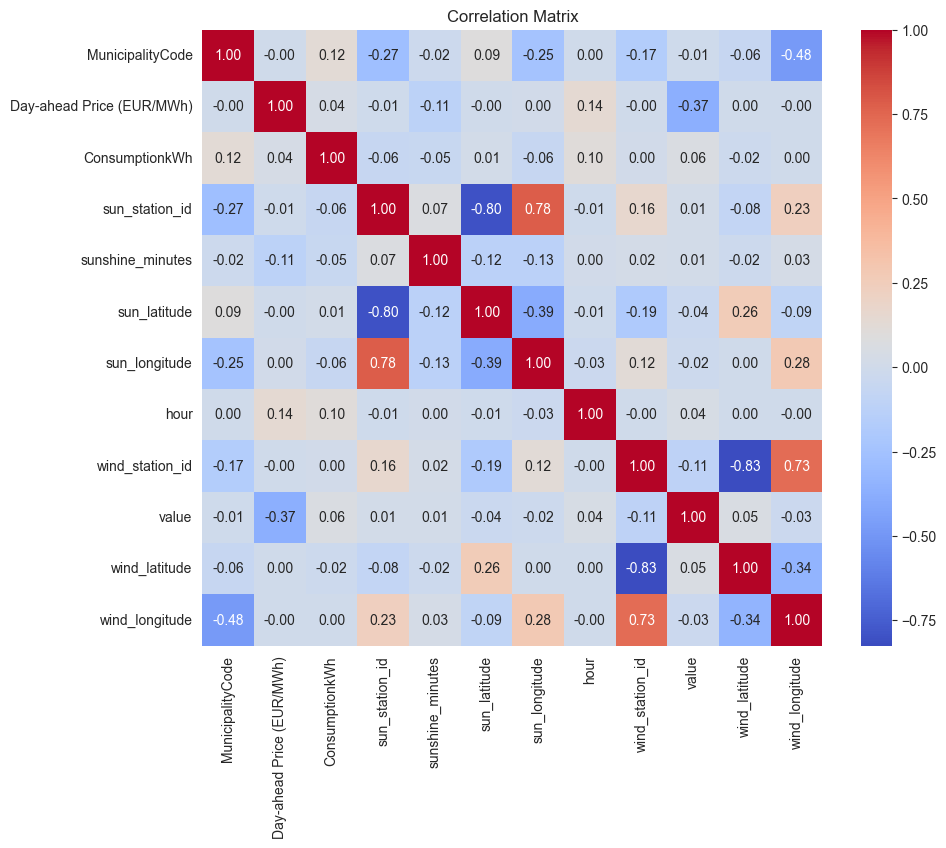

In [16]:
# Normalize datetimes
day_ahead = normalize_datetime(day_ahead, 'MTU (UTC)')
consumption = normalize_datetime(consumption, 'TimeUTC')

consumption = (
    consumption.groupby(["datetime", "MunicipalityCode"], as_index=False)
      .agg({
        "ConsumptionkWh": "sum",
        "TimeDK": "first",
        "Municipality": "first",
        "RegionName": "first",
        "CalculatedDKArea": "first"
    })
)

dfs = [day_ahead, consumption, sunlight, wind]

# Make sure datetime is uniform
for i in range(len(dfs)):
    dfs[i]["datetime"] = pd.to_datetime(dfs[i]["datetime"], utc=True)

    # Ensure all required columns exist
    for col in ["CalculatedDKArea", "MunicipalityCode"]:
        if col not in dfs[i].columns:
            dfs[i][col] = None   # or a sensible default
    dfs[i] = dfs[i].set_index(["datetime", "CalculatedDKArea", "MunicipalityCode"])

# Outer-join all datasets by aligning on the MultiIndex
merged = dfs[0]
for dataframe in dfs[1:]:
    merged = merged.join(dataframe, how="outer", rsuffix="_other")

# Bring keys back as columns
merged = merged.reset_index()

# Fill missing data if needed
merged = merged.ffill()

# Fill NaN values and remove some NaN rows
merged['sunshine_minutes'] = merged['sunshine_minutes'].fillna(0).astype("float64")
merged = merged.dropna(subset=['value'])

# Calculate correlation matrix only on numeric columns
correlation_matrix = merged.select_dtypes(include="number").corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

### Checking for outliers
A method to check for outliers is a boxplot

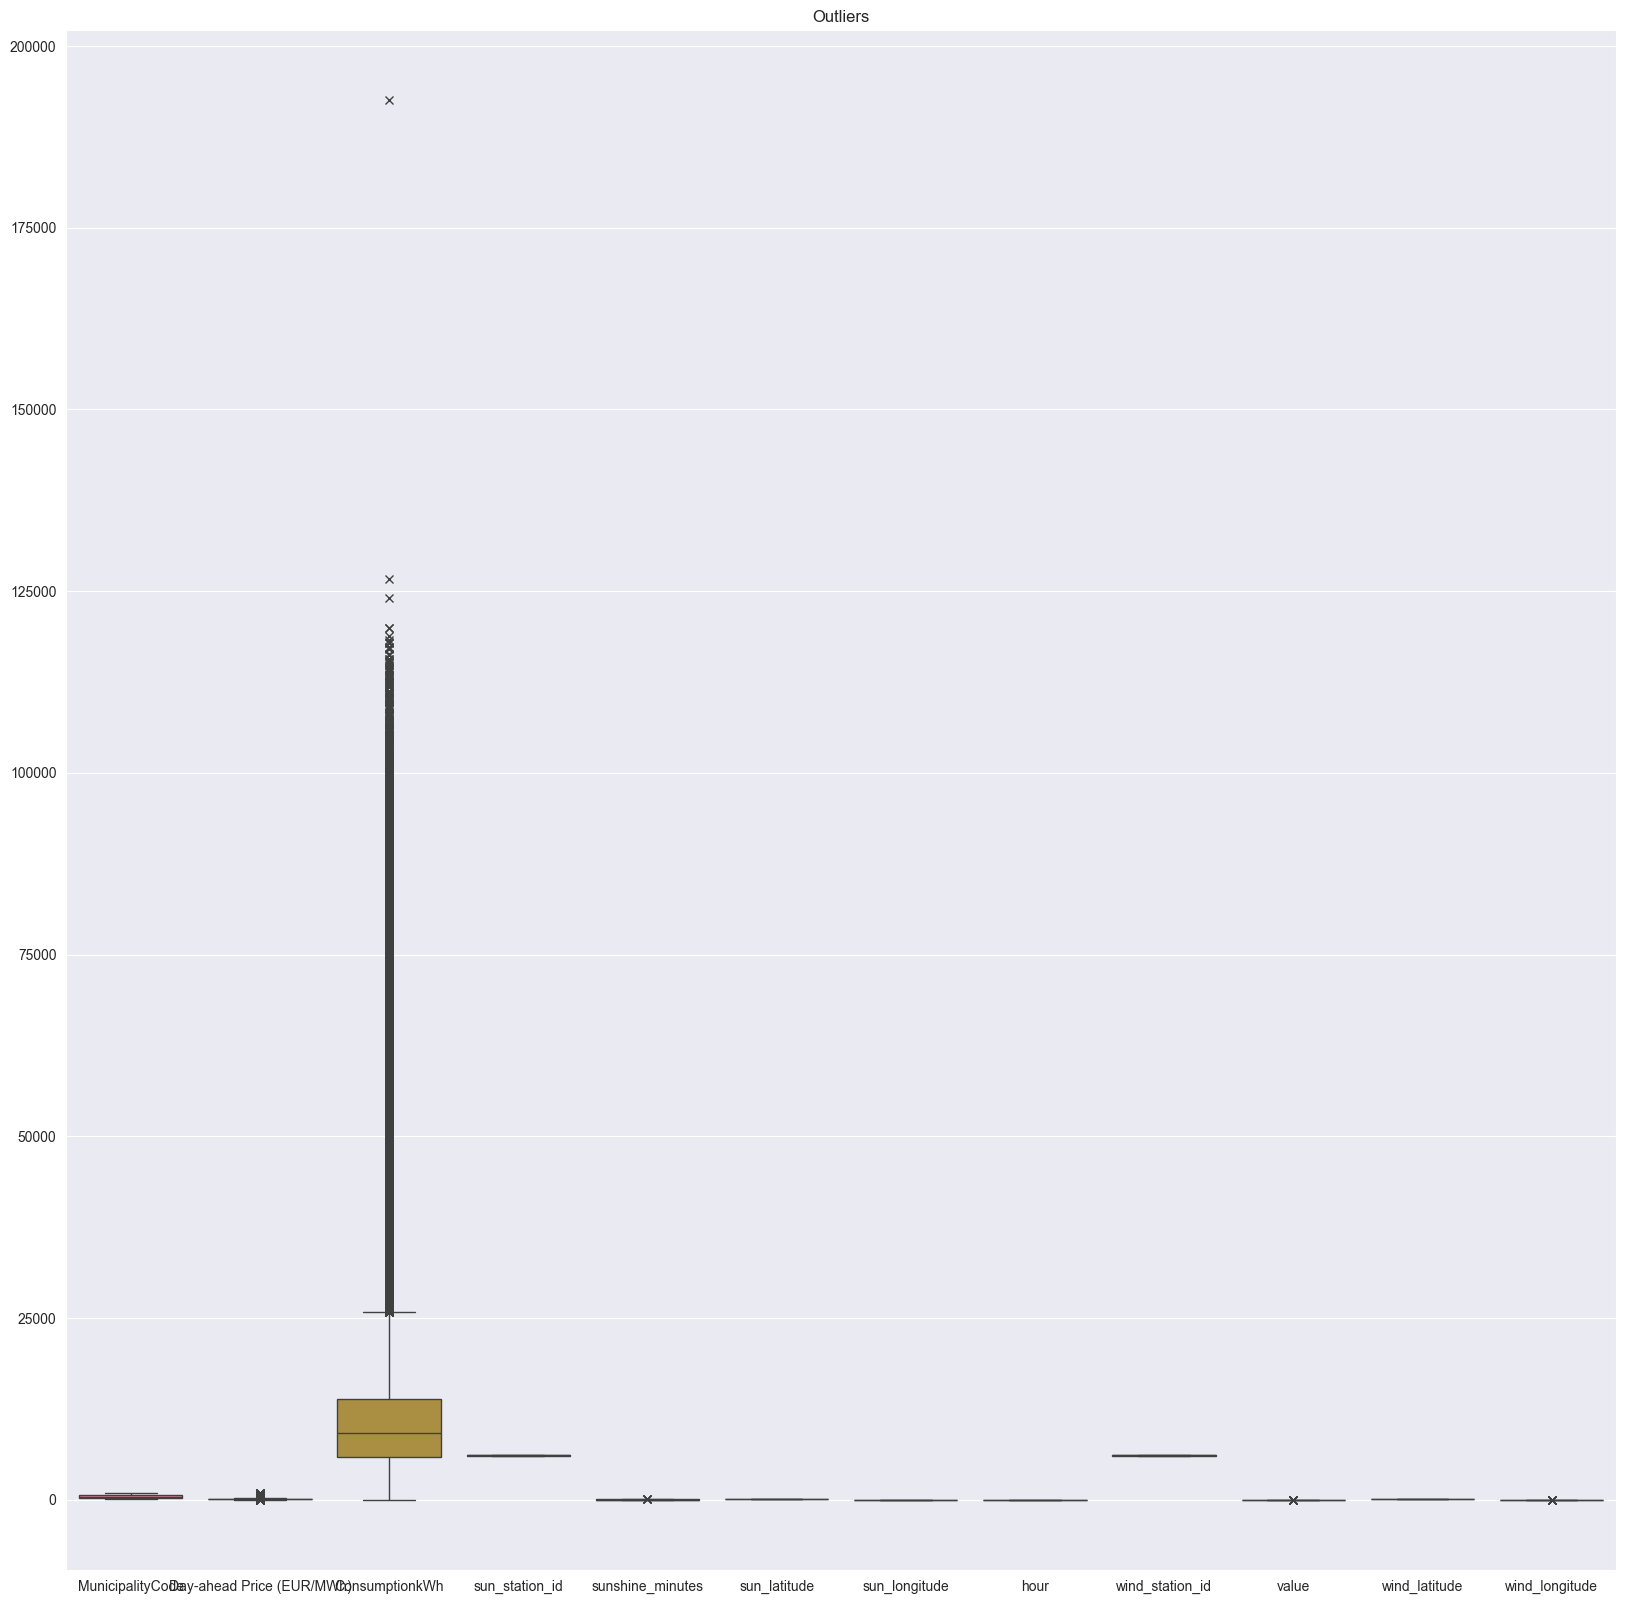

In [17]:
plt.figure(figsize=(20,20))
sns.boxplot(merged, flierprops={"marker": "x"}).set(title="Outliers")
plt.show()